In [1]:
from scipy import stats
import pandas as pd
import seaborn as sb
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [2]:
#There are 3 Diffacto output files:

#1 proteins (w weighted geomean)
proteins_file = '/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_proteins.tsv'
proteins_gmean = pd.read_csv(proteins_file, sep = '\t' )

qproteins_gmean = proteins_gmean[proteins_gmean["S/N"] > -20]
ohw = proteins_gmean[proteins_gmean["S/N"] == -np.inf]
qproteins_gmean = pd.concat([qproteins_gmean, ohw])

num_samples, num_replica = 5,4

samples = [s for s in proteins_gmean.columns if "_" in s]

samples_r = np.array(samples).reshape(num_samples,num_replica)


#convert back to linear space:
proteins_gmean[samples] = 2**proteins_gmean[samples]
qproteins_gmean[samples] = 2**qproteins_gmean[samples]

#2 all peptides (linear scale or log2) + last col protein name
peptides_file = '/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_peptides.tsv' 
peptides = pd.read_csv(peptides_file, sep = '\t' )

#3 used peptides (linear scale or log2, loading > 0.5) + last col protein name
qpeptides_file = '/home/vitalv/cyano_dataset_20170421/diffacto/diffacto_out_usedPeptides.tsv' 
qpeptides = pd.read_csv(qpeptides_file, sep = '\t' )


#Other Protein summarizaton methods.
proteins_mean = qpeptides.groupby("protein").mean()[samples]
proteins_sum = qpeptides.groupby("protein").sum()[samples]


In [3]:
#ADD categories to proteins:
category_f = "/home/vitalv/database/category.txt"
category_df = pd.read_csv(category_f, delimiter="\t", header=None)
category_df.columns = ["geneID", "definition", "first_category_ID", "first_category_name", "second_category_ID", "second_category_name"]

go_terms_f = "/home/vitalv/database/goterm.txt"
go_df = pd.read_csv(go_terms_f, delimiter="\t", header=None, names=["species", "geneID", "annotation_type", "go_term"])

#Read Michael's categories from constraint_protein_fractions.tab
cpf_f = "/home/vitalv/cyano_dataset_20170421/constraint_protein_fractions.tab"
cpf_df = pd.read_csv(cpf_f, delimiter="\t") #header is set to 0 by default, good 
path2model = dict(zip(cpf_df.Pathway, cpf_df.model_component))

#and add them to category_df (AAT, PSET, RIB, etc...)
for i, r in category_df.iterrows():
	if r.first_category_name in path2model.keys():
		category_df.loc[i, "model_component"] = path2model[r.first_category_name]
	elif r.second_category_name in path2model.keys():
		category_df.loc[i, "model_component"] = path2model[r.second_category_name]


In [4]:
proteins = qproteins_gmean

proteins = pd.merge(proteins, category_df, left_on='Protein', right_on='geneID', how='left')

#can't merge go_df with proteins, go_df has many rows per protein
#pd.merge(proteins, cpf_df[["Pathway", "model_component"]], left_on='second_category_name', right_on='Pathway')

#Note that there will be a few proteins with model_component NaN
#proteins[proteins.model_component.isnull()] #16
#which means that my group mass fractions won't add up to total mass becuse there are proteins that don't belong to any of the groups
#Just assign them to MAI for now:
proteins.model_component.fillna("MAI", inplace=True)


In [5]:
num_samples, num_replica = 5,4
groups = [c for c in list(set(proteins.model_component)) if type(c) == str]
groups = ['LHC', 'STA', 'AAB', 'LPB', 'PRM', 'PSET', 'MAI', 'RIB']


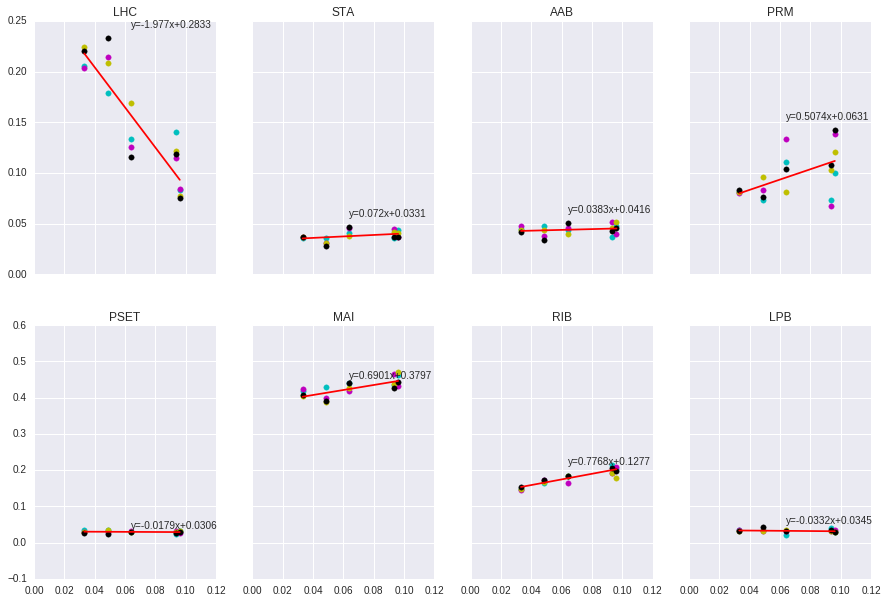

In [6]:
f, axs = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(15, 10))
colors = ['c', 'm', 'y', 'k']
Xs = [0.0331, 0.0485, 0.0639, 0.0934, 0.0961]
for i in range(len(groups)):
	df = proteins[proteins.model_component == groups[i]]
	Ys = []
	for s in samples: 
		total_mass = proteins[s].sum()
		group_mass = df[s].sum()
		group_mass_fraction = group_mass / total_mass
		Ys.append(group_mass_fraction)
	c=0
	repl_Ys = np.array(Ys).reshape(num_samples, num_replica).T
	sampl_Ys = np.array(Ys).reshape(num_samples, num_replica)
	s_medians = [np.median(y) for y in sampl_Ys]
	for Ys in repl_Ys:
		ax = axs.flatten()[i]
		scatter = ax.scatter(Xs, Ys, color=colors[c], s=30)
		ax.set_title(groups[i])
		c+=1
	slope, intercept, r_value, p_value, std_err = stats.linregress(Xs,s_medians)
	line = slope*np.array(Xs)+intercept
	ax.plot(Xs, line, color='r')
	ax.text(Xs[2], max(Ys+0.01), "y=%sx+%s"%(round(slope,4), round(intercept,4)))
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


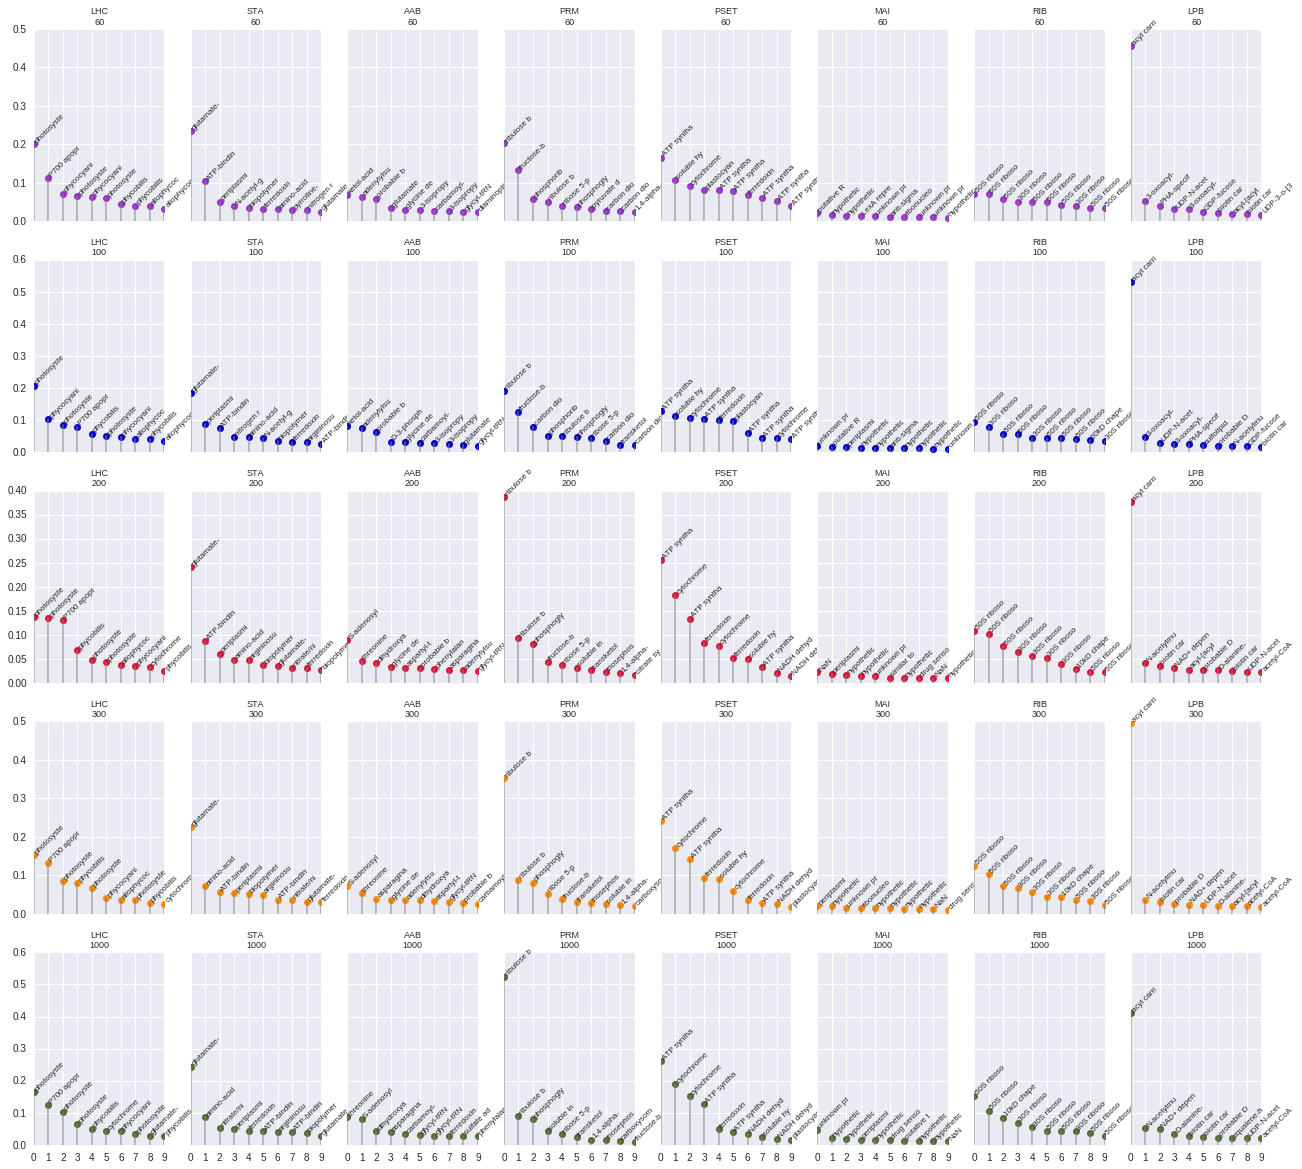

In [7]:
#Fill NaN under definition replacing with "NaN"
#Protein groups have NaN
proteins.definition.fillna("NaN", inplace=True)

colors = ['darkorchid', 'mediumblue', 'crimson', 'darkorange', 'darkolivegreen']
f, axs = plt.subplots(num_samples, len(groups), sharex='col', sharey='row', figsize=(22, 20))
for g in range(len(groups)): #columns in subplots
	df = proteins[proteins.model_component == groups[g]]
	for i in range(len(samples_r)): #rows in subplots
		s = samples_r[i]
		m_sample = "mean_%s"%s[0].split("_")[0]
		df[m_sample] = df[s].mean(axis=1)
		total_m_sample = df[s].sum().mean()
		m_fraction = "fraction_%s"%s[0].split("_")[0]
		df[m_fraction] = df[m_sample] / total_m_sample
		Xs = range(10)
		Ys = list(df.sort_values(m_fraction, ascending=False)[:10][m_fraction])
		top = list(df.sort_values(m_fraction, ascending=False)[:10].definition)
		top = [t[0:10] for t in top] #definition too long
		ax = axs[i][g]
		ax.plot(Xs, Ys, 'o', color=colors[i])
		ax.set_title("%s\n%s"%(groups[g], m_sample.split("_")[1]), fontsize=9)
		for j in range(len(Xs)): 
			ax.plot([Xs[j],Xs[j]], [0, Ys[j]], color='gray', alpha=0.6)
			ax.text(Xs[j], Ys[j], top[j], rotation=45, fontsize=8, va='bottom')
plt.show()

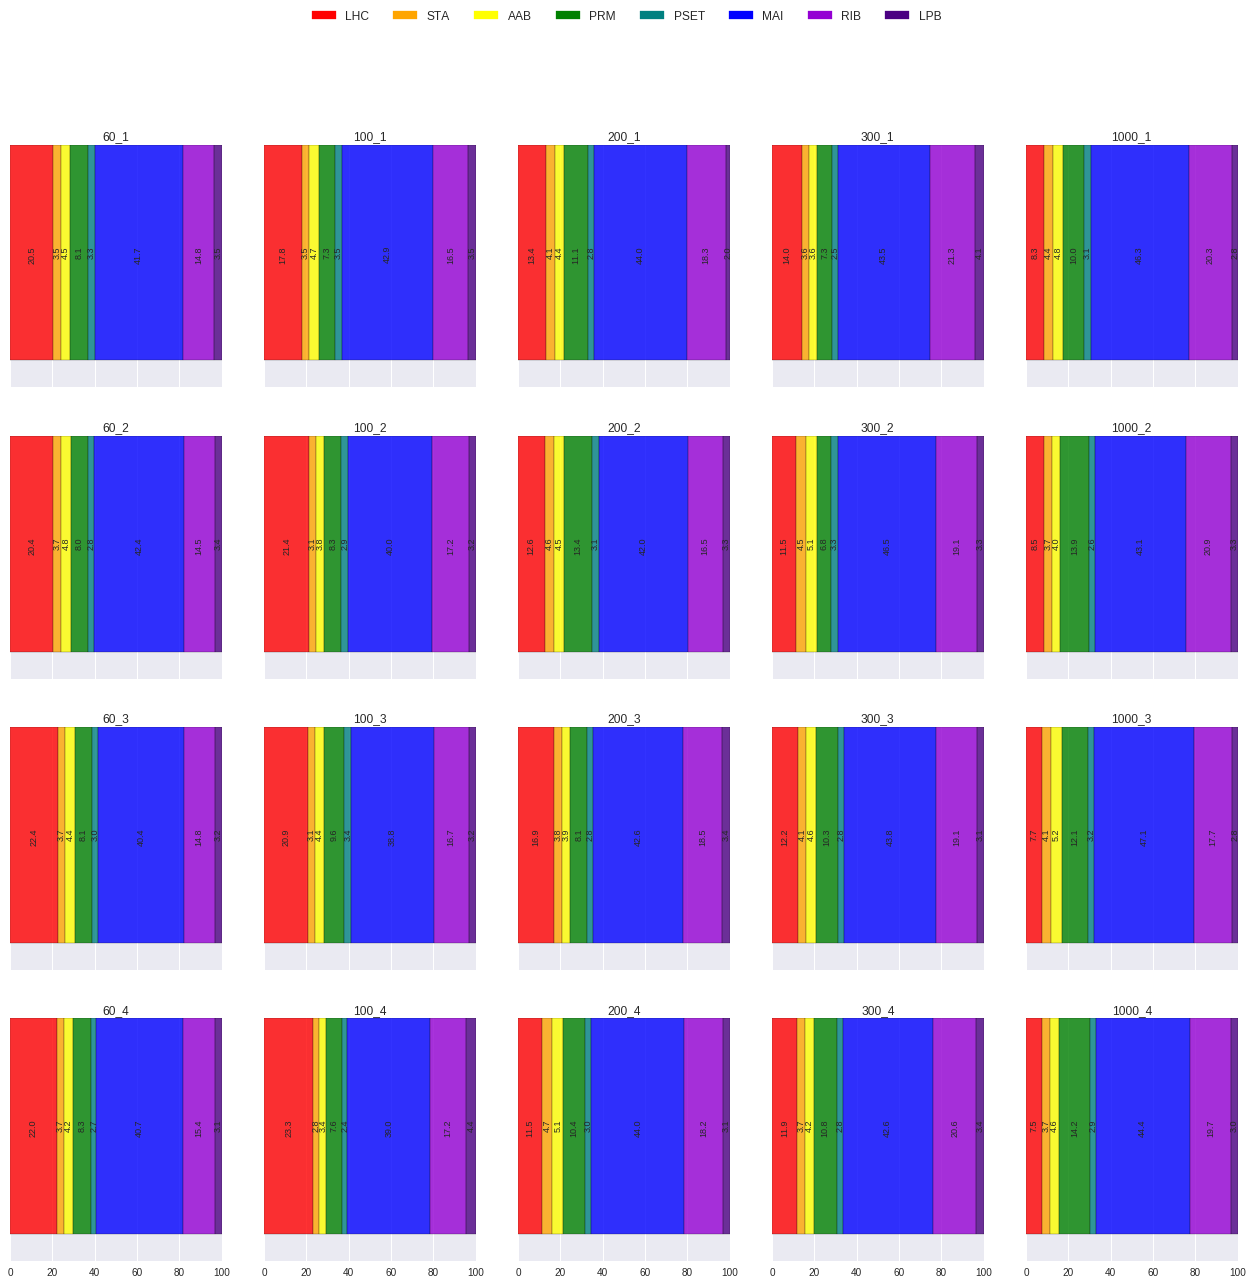

In [8]:
colors = ["red", "orange", "yellow", "green", "teal", "blue", "darkviolet", "indigo"]  #1 color per group : 8 colors
color_patches = []
f, axs = plt.subplots(num_replica, num_samples, sharex='col', figsize=(22, 20))
repl_ix = [i%num_replica for i in range(len(samples))]
sampl_ix = sorted([i%num_samples for i in range(len(samples))])
h = 0.8
for i in range(len(samples)):
	s = samples[i]
	cumulative = 0
	for j in range(len(groups)):
		g = groups[j]
		df = proteins[proteins.model_component == g]
		total_mass = proteins[s].sum()
		group_mass = df[s].sum()
		fraction_mass = (group_mass / total_mass)*100
		cumulative += fraction_mass
		left = cumulative - fraction_mass
		subpl_row = repl_ix[i]
		subpl_col = sampl_ix[i]
		ax = axs[subpl_row][subpl_col]
		ax.barh(1, fraction_mass, height=h, left=left, color=colors[j], alpha=0.8)
		ax.text(left+(fraction_mass/2), 1+(h/2), round(fraction_mass,1), fontsize=9, ha='center', rotation=90)
		ax.set_title(s, fontsize=12)
		ax.set_xlim([0,100])
		ax.get_yaxis().set_visible(False)
		if i == 0:
			patch = mpatches.Patch(color=colors[j], label=g)
			color_patches.append(patch)
plt.figlegend(handles=color_patches, labels=groups, fontsize=12, loc="upper center", ncol=len(groups))
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


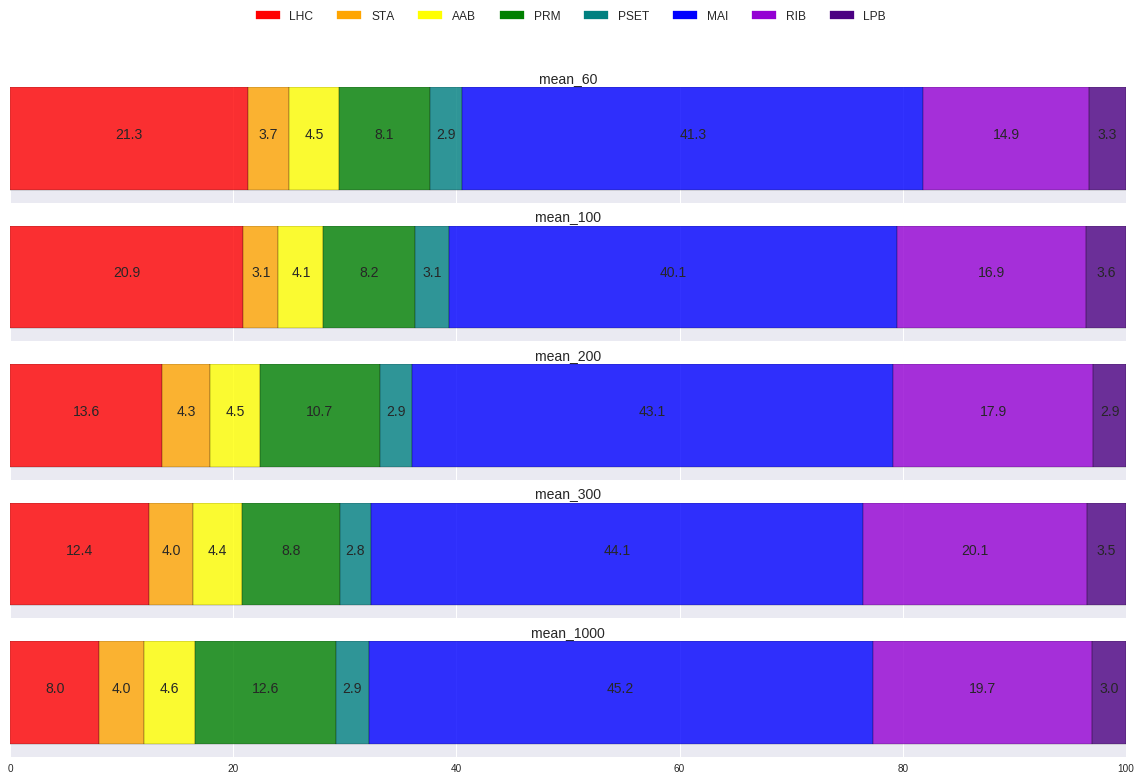

In [18]:
colors = ["red", "orange", "yellow", "green", "teal", "blue", "darkviolet", "indigo"]  #1 color per group : 8 colors
color_patches = []
f, axs = plt.subplots(num_samples, 1, sharex='col', figsize=(20,12))
for i in range(len(samples_r)): 
	s = samples_r[i]
	cumulative = 0
	for j in range(len(groups)):
		g = groups[j]
		df = proteins[proteins.model_component == g]
		m_sample = "mean_%s"%s[0].split("_")[0]
		df[m_sample] = df[s].mean(axis=1)
		proteins[m_sample] = proteins[s].mean(axis=1)	
		total_mass = proteins[m_sample].sum()
		group_mass = df[m_sample].sum()
		fraction_mass = (group_mass / total_mass)*100
		cumulative += fraction_mass
		left = cumulative - fraction_mass
		axs[i].barh(1, fraction_mass, height=0.8, left=left, color=colors[j], alpha=0.8)
		axs[i].text(left+(fraction_mass/2), 1+(h/2), round(fraction_mass,1), fontsize=14, ha='center')#, rotation=90)
		axs[i].set_title(m_sample, fontsize=14)
		axs[i].set_xlim([0,100])
		axs[i].get_yaxis().set_visible(False)
		if i == 0:
			patch = mpatches.Patch(color=colors[j], label=g)
			color_patches.append(patch)
plt.figlegend(handles=color_patches, labels=groups, fontsize=12, loc="upper center", ncol=len(groups))
plt.show()
